<a href="https://colab.research.google.com/github/Satyam1Gupta/Sentiment-Analysis-LSTM/blob/main/Sentiment-Analysis-using-Glove-SNN-CNN-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting the environment

In [38]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical


## Loading dataset

In [6]:

twitter_data = pd.read_excel("/content/Final_balanced_sentiment_data.xlsx")

twitter_data

,text,sentiment
0,what did just say vote for modi welcome bjp t...,1
1,asking his supporters prefix chowkidar their n...,1
2,answer who among these the most powerful world...,1
3,with upcoming election india saga going import...,1
4,gandhi was gay does modi,1
...,...,...
131356,what modi saying against democracy should flee...,0
131357,niti aayog accessory for the modi government m...,0
131358,mrjairam here answer lies bjp godi media many ...,0
131359,india prime ministerasaduddin owaisi slams mod...,0


from matplotlib import pyplot as plt
movie_reviews['sentiment'].plot(kind='hist', bins=20, title='sentiment')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
movie_reviews['sentiment'].plot(kind='line', figsize=(8, 4), title='sentiment')
plt.gca().spines[['top', 'right']].set_visible(False)

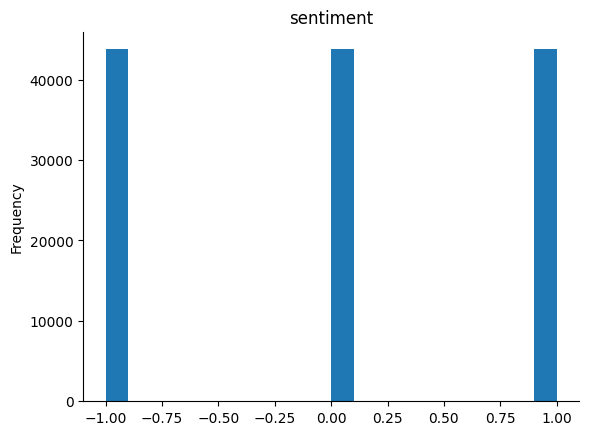

In [59]:
from matplotlib import pyplot as plt
twitter_data['sentiment'].plot(kind='hist', bins=20, title='sentiment')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [60]:
# Dataset exploration

twitter_data.shape

(131359, 2)

In [61]:
twitter_data.head(5)

,text,sentiment
0,what did just say vote for modi welcome bjp t...,1
1,asking his supporters prefix chowkidar their n...,1
2,answer who among these the most powerful world...,1
3,with upcoming election india saga going import...,1
4,gandhi was gay does modi,1


In [62]:
# Checking for missing values

twitter_data.isnull().values.sum()

0

In [63]:
# Delete rows with any null values
twitter_data = twitter_data.dropna()

# Verify that there are no missing values left
missing_values_cleaned = twitter_data.isnull().sum()
print(missing_values_cleaned)

text         0
sentiment    0
dtype: int64


<Axes: xlabel='sentiment', ylabel='count'>

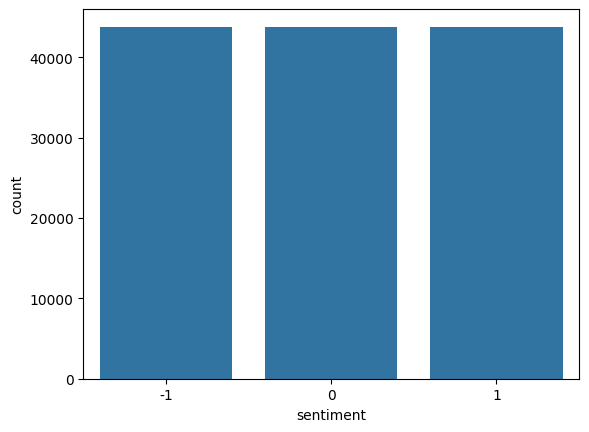

In [64]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=twitter_data)

## Data Preprocessing

In [65]:
twitter_data["text"][2]

# You can see that our text contains punctuations, brackets, HTML tags and numbers
# We will preprocess this text in the next section

'answer who among these the most powerful world leader today trump putin modi may '

In [67]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [68]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [69]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    sentence=sen
    # sentence = sen.lower()

    # # Remove html tags
    # sentence = remove_tags(sentence)

    # # Remove punctuations and numbers
    # sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [70]:
# Calling preprocessing_text function on twitter_data

X = []
sentences = list(twitter_data['text'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [71]:
# Sample cleaned up movie review

X[2]

# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here

'answer among powerful world leader today trump putin modi may '

In [72]:
# Converting sentiment labels to 0 & 1

y = twitter_data['sentiment']

# y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs

## Preparing embedding layer

Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [117]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [110]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

88154

In [118]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [82]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [83]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [84]:
embedding_matrix.shape

(88154, 100)

# Model Training with:

## Simple Neural Network

In [85]:
# Neural Network architecture

# snn_model = Sequential()
# embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

# snn_model.add(embedding_layer)

# snn_model.add(Flatten())
# snn_model.add(Dense(1, activation='sigmoid'))
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
snn_model.add(embedding_layer)
snn_model.add(Flatten())
snn_model.add(Dense(3, activation='softmax'))  # 3 output nodes for 3 classes


In [86]:
# Model compiling

# snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

snn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(snn_model.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          8815400   
                                                                 
 flatten_3 (Flatten)         (None, 10000)             0         
                                                                 
 dense_3 (Dense)             (None, 3)                 30003     
                                                                 
Total params: 8845403 (33.74 MB)
Trainable params: 30003 (117.20 KB)
Non-trainable params: 8815400 (33.63 MB)
_________________________________________________________________
None


In [87]:
# y_train = to_categorical(y_train, num_classes=3)
# y_test = to_categorical(y_test, num_classes=3)
# print(y_train.shape)
# print(y_test.shape)


# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# Now print the shapes to verify
print("Corrected Shapes:")
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Corrected Shapes:
y_train shape: (105087, 3)
y_test shape: (26272, 3)


In [88]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
657/657 [==============================] - 8s 12ms/step - loss: 0.9058 - accuracy: 0.5788 - val_loss: 0.8761 - val_accuracy: 0.6032
Epoch 2/6
657/657 [==============================] - 9s 13ms/step - loss: 0.8479 - accuracy: 0.6205 - val_loss: 0.8664 - val_accuracy: 0.6120
Epoch 3/6
657/657 [==============================] - 8s 12ms/step - loss: 0.8341 - accuracy: 0.6272 - val_loss: 0.8709 - val_accuracy: 0.6127
Epoch 4/6
657/657 [==============================] - 5s 7ms/step - loss: 0.8267 - accuracy: 0.6304 - val_loss: 0.8746 - val_accuracy: 0.6076
Epoch 5/6
657/657 [==============================] - 6s 9ms/step - loss: 0.8236 - accuracy: 0.6330 - val_loss: 0.8723 - val_accuracy: 0.6094
Epoch 6/6
657/657 [==============================] - 9s 14ms/step - loss: 0.8207 - accuracy: 0.6347 - val_loss: 0.8738 - val_accuracy: 0.6101


In [89]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

821/821 [==============================] - 2s 2ms/step - loss: 0.8662 - accuracy: 0.6132


In [90]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.8661549687385559
Test Accuracy: 0.6131622791290283


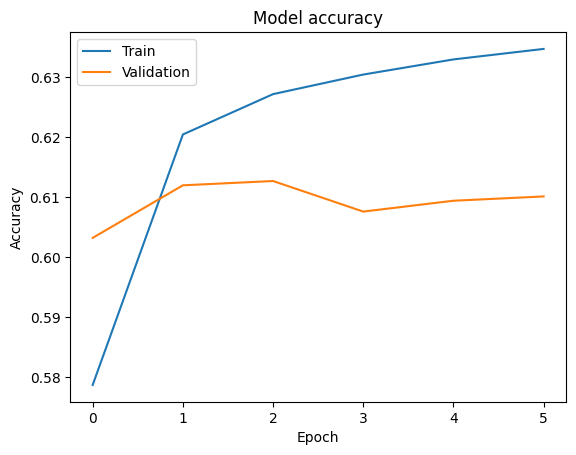

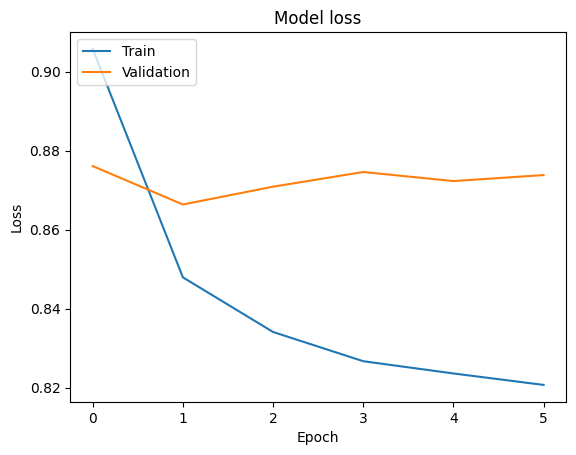

In [92]:
# Model Performance Charts

# import matplotlib.pyplot as plt

# plt.plot(snn_model_history.history['acc'])
# plt.plot(snn_model_history.history['val_acc'])

# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train','test'], loc='upper left')
# plt.show()

# plt.plot(snn_model_history.history['loss'])
# plt.plot(snn_model_history.history['val_loss'])

# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train','test'], loc='upper left')
# plt.show()

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(snn_model_history.history['accuracy'])
plt.plot(snn_model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Convolutional Neural Network

In [93]:
from keras.layers import Conv1D

In [112]:
# # Neural Network architecture

# cnn_model = Sequential()

# embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
# cnn_model.add(embedding_layer)

# cnn_model.add(Conv1D(128, 5, activation='relu'))
# cnn_model.add(GlobalMaxPooling1D())
# cnn_model.add(Dense(1, activation='sigmoid'))


# Define the model
cnn_model = Sequential()

# Embedding layer
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
cnn_model.add(embedding_layer)

# Convolutional layer
cnn_model.add(Conv1D(128, 5, activation='relu'))

# Global max pooling layer
cnn_model.add(GlobalMaxPooling1D())

# Output layer for 3 classes
cnn_model.add(Dense(3, activation='softmax'))  # 3 output units for 3 classes, softmax for multi-class classification

In [121]:
# Model compiling

# cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# print(cnn_model.summary())


cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
print(cnn_model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 100)          8815400   
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 3)                 387       
                                                                 
Total params: 8879915 (33.87 MB)
Trainable params: 64515 (252.01 KB)
Non-trainable params: 8815400 (33.63 MB)
_________________________________________________________________
None


In [122]:
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# Now print the shapes to verify
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (105087, 3)
y_test shape: (26272, 3)


In [123]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
657/657 [==============================] - 77s 116ms/step - loss: 0.7805 - accuracy: 0.6518 - val_loss: 0.6725 - val_accuracy: 0.7200
Epoch 2/6
657/657 [==============================] - 84s 128ms/step - loss: 0.5973 - accuracy: 0.7607 - val_loss: 0.6150 - val_accuracy: 0.7535
Epoch 3/6
657/657 [==============================] - 77s 117ms/step - loss: 0.5097 - accuracy: 0.8051 - val_loss: 0.5905 - val_accuracy: 0.7656
Epoch 4/6
657/657 [==============================] - 86s 131ms/step - loss: 0.4464 - accuracy: 0.8328 - val_loss: 0.5951 - val_accuracy: 0.7659
Epoch 5/6
657/657 [==============================] - 83s 126ms/step - loss: 0.3933 - accuracy: 0.8563 - val_loss: 0.5950 - val_accuracy: 0.7686
Epoch 6/6
657/657 [==============================] - 76s 116ms/step - loss: 0.3555 - accuracy: 0.8723 - val_loss: 0.6043 - val_accuracy: 0.7719


In [124]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

821/821 [==============================] - 10s 12ms/step - loss: 0.6133 - accuracy: 0.7648


In [125]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6133131980895996
Test Accuracy: 0.7647686004638672


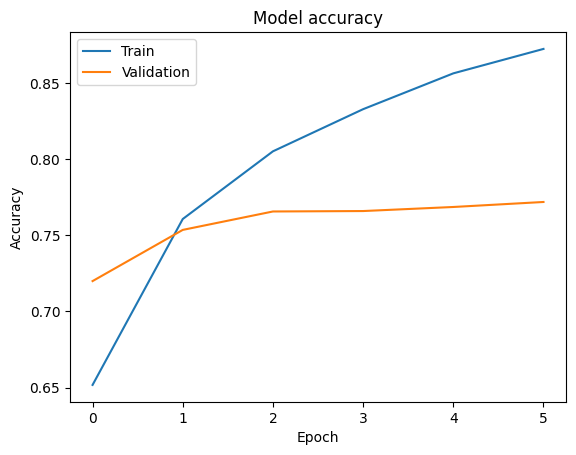

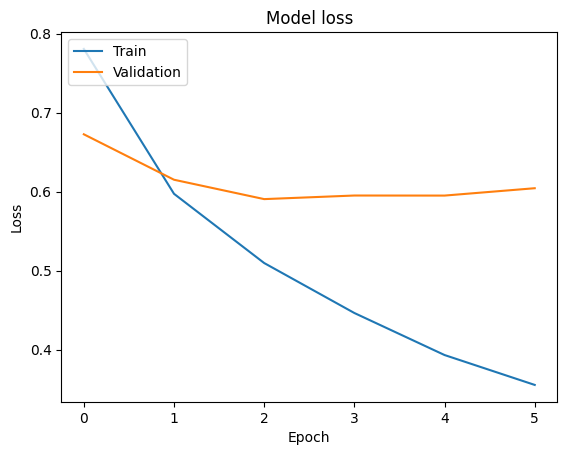

In [128]:
# # Model Performance Charts

# import matplotlib.pyplot as plt

# plt.plot(cnn_model_history.history['acc'])
# plt.plot(cnn_model_history.history['val_acc'])

# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train','test'], loc = 'upper left')
# plt.show()

# plt.plot(cnn_model_history.history['loss'])
# plt.plot(cnn_model_history.history['val_loss'])

# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train','test'], loc = 'upper left')
# plt.show()


import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(cnn_model_history.history['accuracy'])
plt.plot(cnn_model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Recurrent Neural Network (LSTM)

In [129]:
from keras.layers import LSTM

In [130]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(3, activation='softmax'))

In [131]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          8815400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_7 (Dense)             (None, 3)                 387       
                                                                 
Total params: 8933035 (34.08 MB)
Trainable params: 117635 (459.51 KB)
Non-trainable params: 8815400 (33.63 MB)
_________________________________________________________________
None


In [ ]:
# y_train = to_categorical(y_train, num_classes=3)
# y_test = to_categorical(y_test, num_classes=3)

# Now print the shapes to verify
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

In [132]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
657/657 [==============================] - 330s 424ms/step - loss: 0.5974 - acc: 0.4232 - val_loss: 0.5228 - val_acc: 0.5701
Epoch 2/6
657/657 [==============================] - 291s 443ms/step - loss: 0.4837 - acc: 0.6442 - val_loss: 0.5283 - val_acc: 0.5882
Epoch 3/6
657/657 [==============================] - 290s 442ms/step - loss: 0.4665 - acc: 0.6619 - val_loss: 0.4267 - val_acc: 0.7007
Epoch 4/6
657/657 [==============================] - 294s 447ms/step - loss: 0.4042 - acc: 0.7210 - val_loss: 0.3901 - val_acc: 0.7342
Epoch 5/6
657/657 [==============================] - 278s 424ms/step - loss: 0.3695 - acc: 0.7523 - val_loss: 0.3718 - val_acc: 0.7529
Epoch 6/6
657/657 [==============================] - 293s 446ms/step - loss: 0.3464 - acc: 0.7714 - val_loss: 0.3468 - val_acc: 0.7725


In [133]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

821/821 [==============================] - 63s 76ms/step - loss: 0.3433 - acc: 0.7752


In [134]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3432861864566803
Test Accuracy: 0.7752360105514526


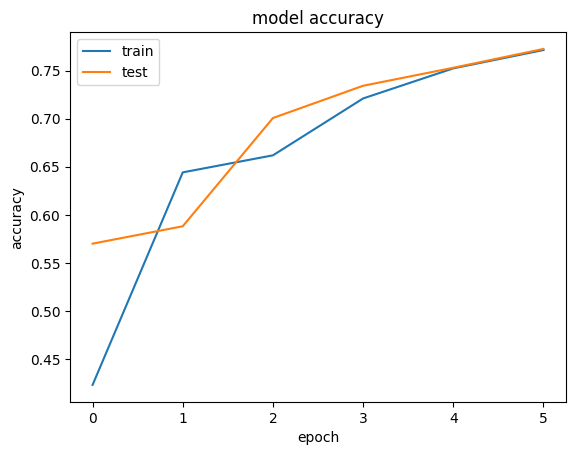

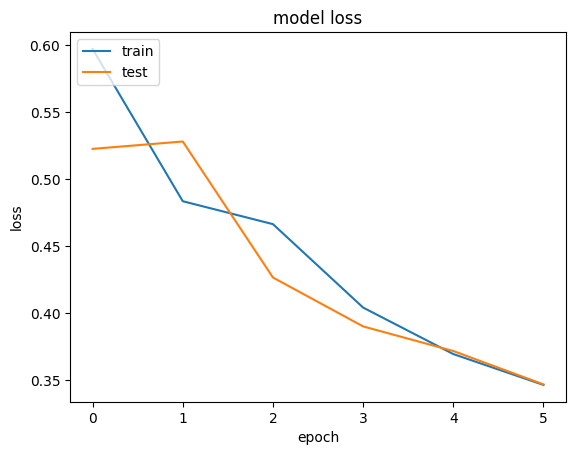

In [135]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

# Making Predictions on Live IMDb data

In [ ]:
!ls # lists files in working directory

a1_IMDB_Dataset.csv	    b_SentimentAnalysis_with_NeuralNetwork.ipynb
a2_glove.6B.100d.txt	    c1_lstm_model_acc_0.856.h5
a3_IMDb_Unseen_Reviews.csv  c1_lstm_model_acc_0.864.h5


In [ ]:
# # Load previously trained LSTM Model

# from keras.models import load_model

# model_path ='./c1_lstm_model_acc_0.856.h5'
# pretrained_lstm_model = load_model(model_path)

# # summarize model.
# pretrained_lstm_model.summary()

In [ ]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv("a3_IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [ ]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [ ]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [ ]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

array([[0.8834934 ],
       [0.9929012 ],
       [0.31473452],
       [0.2754807 ],
       [0.97470117],
       [0.04180595]], dtype=float32)

In [ ]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,8.8
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.9
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,3.1
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,2.8
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.7
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.4
